In [1]:
import pathlib
import scipy.constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fytok.Tokamak import Tokamak
from fytok.modules.CoreProfiles import CoreProfiles
from fytok.modules.Equilibrium import Equilibrium
from spdm.view import View as sp_view
from spdm.data.Path import Path
from spdm.data.Function import Function

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

astra_profiles = pd.read_excel(
    next(data_path.glob("*ASTRA.xls")).absolute().as_posix(), sheet_name=1, header=10, usecols="B:BN"
)

2024-01-20 16:58:46,442 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2024-01-20T16:58:46.318609.
 Job ID: fytok_salmon_surface_24349

###################################################################################################



In [2]:
core_profiles_astra = CoreProfiles(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_profiles"
)

core_profiles_1d_astra = core_profiles_astra.time_slice.current.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium")

2024-01-20 16:58:46,795 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2024-01-20 16:58:46,859 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-20 16:58:46,905 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2024-01-20 16:58:46,907 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk
2024-01-20 16:58:46,924 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 


In [3]:
tokamak = Tokamak(
    device="iter",
    shot=900003,
    equilibrium=f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium",
    core_transport={
        "model": [
            {"code": {"name": "predefined"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_sources/source/0",
            {"code": {"name": "collisional_equipartition", "ii_collision": True}},
            {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"]}}},
            # {"code": {"name": "radiation"}},
            # {"code": {"name": "synchrotron_radiation"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 1.0, 128),
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "psi": 10,
                    "psi_flux": 10,
                    "*/density": 1.0e21,
                    "*/density_flux": 1.0e24,
                    "ion/alpha/density": 1.0e18,
                    "ion/alpha/density_flux": 1.0e21,
                    "*/temperature": 1.0e6,
                    "*/temperature_flux": 1.0e27,
                },
            },
        },
        "ion_thermal": ["D", "T"],  #
        "ion_non_thermal": ["alpha", "He"],
        # "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            "psi_norm"                  : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)

2024-01-20 16:58:46,950 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml


In [4]:
tokamak.initialize()

2024-01-20 16:58:46,972 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-20 16:58:46,991 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2024-01-20 16:58:46,998 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2024-01-20 16:58:47,000 [    spdm]     INFO: Initialize module fytok.modules.TF 
2024-01-20 16:58:47,005 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2024-01-20 16:58:47,008 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2024-01-20 16:58:47,015 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2024-01-20 16:58:47,073 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.dummy 
2024-01-20 16:58:47,082 [    spdm]     INFO: Load module fytok.plugins.core_sources.source.collisional_equipartition
2024-01-20 16:58:47,086 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.collisional_equipartition 
2024-01-20 16:58:47,093 [    spdm

2024-01-20 16:58:47,172 [    spdm]     INFO: Load module spdm.view.view_matplotlib
2024-01-20 16:58:47,210 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular
2024-01-20 16:58:47,217 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:94:__init__: Create FyEquilibriumCoordinateSystem <FyEquilibriumCoordinateSystem name='unnamed.equilibrium.unnamed.coordinate_system' />
2024-01-20 16:58:47,365 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:132:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0


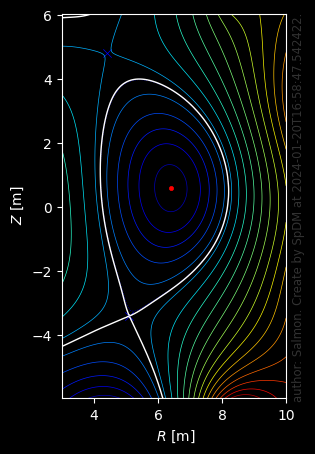

In [5]:
fig = sp_view.display(tokamak.equilibrium, format="svg")

In [6]:
tokamak.equilibrium.time_slice.current.profiles_1d.grid

unnamed.equilibrium.unnamed.profiles_1d.grid

In [7]:
tokamak.equilibrium.refresh()
tokamak.core_profiles.refresh()
tokamak.core_sources.refresh()
tokamak.core_transport.refresh()

2024-01-20 16:58:48,483 [    spdm]     INFO: Execute module fytok.plugins.equilibrium.FyEqAnalyze
2024-01-20 16:58:48,490 [    spdm]     INFO: Execute module fytok.modules.CoreProfiles
2024-01-20 16:58:48,492 [    spdm]     INFO: Execute module fytok.modules.CoreSources
2024-01-20 16:58:48,495 [    spdm]     INFO: Execute module fytok.plugins.core_sources.source.dummy
2024-01-20 16:58:48,499 [    spdm]     INFO: Execute module fytok.plugins.core_sources.source.collisional_equipartition
2024-01-20 16:58:48,506 [    spdm]     INFO: Execute module fytok.plugins.core_sources.source.fusion
2024-01-20 16:58:48,509 [    spdm]     INFO: Execute module fytok.modules.CoreTransport
2024-01-20 16:58:48,512 [    spdm]     INFO: Execute module fytok.plugins.core_transport.model.predefined


In [8]:
solver = tokamak.transport_solver
eq_grid = tokamak.equilibrium.time_slice.current.profiles_1d.grid
rho_tor_norm = eq_grid.rho_tor_norm[1:-1]
psi_norm = eq_grid.psi_norm[1:-1]

In [9]:
solver_1d = solver.preprocess(
    time=0.0,
    rho_tor_norm=rho_tor_norm,
    # fmt:off
    initial_value={
        "psi":                              0.0,
        "psi_norm":                         psi_norm,
        "ion/D/density":                    core_profiles_1d_astra.ion["D"].density(rho_tor_norm) ,  # 1.0e19,
        "ion/T/density":                    core_profiles_1d_astra.ion["T"].density(rho_tor_norm) ,  # 1.0e19,#
        "ion/He/density":                   core_profiles_1d_astra.ion["He"].density(rho_tor_norm) ,  #1.0e6,
        "ion/alpha/density":                core_profiles_1d_astra.ion["alpha"].density(rho_tor_norm), #1.0e6,

        "ion/D/temperature":                core_profiles_1d_astra.ion["D"].temperature(rho_tor_norm) , # 2.0e3, #
        "ion/T/temperature":                core_profiles_1d_astra.ion["T"].temperature(rho_tor_norm) , # 2.0e3, #
        "ion/He/temperature":               core_profiles_1d_astra.ion["He"].temperature(rho_tor_norm) , # 2.0e3,
        "electrons/temperature":            core_profiles_1d_astra.electrons.temperature(rho_tor_norm) ,# 2.0e3, #
    },
    boundary_value={
        "ion/D/density":                    2.0e19, 
        "ion/T/density":                    2.0e19, 
        "ion/He/density":                   2.0e17, 
        "ion/alpha/density":                1.0, 

        "ion/D/temperature":                200,   
        "ion/T/temperature":                200,   
        "ion/He/temperature":               200,   
        "electrons/temperature":            200,   
    },
    # fmt:on
)

In [10]:
solver_1d = solver.execute(solver_1d)
solver_1d = solver.postprocess(solver_1d)

2024-01-20 16:58:49,137 [    spdm]     INFO: Solve transport equations : psi_norm  ,electrons/temperature  ,ion/T/density  ,ion/T/temperature  ,ion/D/density  ,ion/D/temperature  ,ion/He/density  ,ion/alpha/density
2024-01-20 16:58:49,143 [    spdm]     INFO: Execute module fytok.plugins.transport_solver_numerics.fy_trans
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.17e-02       3.77e-23          127            16       
       2          7.29e-03       1.21e-24          143             5       
       3          1.99e-03       3.80e-22          148             1       
       4          9.37e-04       7.20e-22          149             0       
Solved in 4 iterations, number of nodes 149. 
Maximum relative residual: 9.37e-04 
Maximum boundary residual: 7.20e-22
2024-01-20 16:58:54,598 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fy_trans/fy_trans.py:876:execute: Solve BVP success: The

[4.13027094e-04 1.05854365e-04 1.42682251e-04 1.05254630e-04
 1.71445829e-05 1.80712671e-05 4.95792266e-05 5.10153150e-05
 1.57627311e-05 1.81969344e-05 1.29513771e-05 1.29398291e-05
 1.26526607e-05 1.30477080e-05 1.49244699e-05 8.70619378e-06
 1.64833815e-05 1.16078762e-05 1.79188732e-05 7.51957825e-06
 1.10808944e-05 1.26481736e-05 6.32516407e-06 5.51292702e-06
 1.00638382e-05 1.46081791e-05 1.39762378e-05 1.15051035e-05
 9.24003620e-06 6.04656916e-06 4.15415972e-06 4.37826914e-06
 5.03653608e-06 5.21960530e-06 4.67430462e-06 4.15077085e-06
 4.25580779e-06 6.03996577e-06 7.80123764e-06 8.26732029e-06
 9.40652995e-06 8.56242181e-06 2.53325236e-06 2.05605895e-06
 6.18824519e-06 4.19434861e-06 2.44540578e-06 4.44030711e-06
 1.65506262e-06 5.89860892e-06 1.13810931e-05 9.48117018e-06
 5.31974854e-06 3.47789915e-06 6.67770336e-06 7.35628615e-06
 2.42407748e-06 3.03080535e-06 2.31753944e-06 2.08122902e-06
 1.27681355e-06 2.12622202e-06 4.50351595e-06 8.05068662e-06
 3.37127042e-06 4.739143

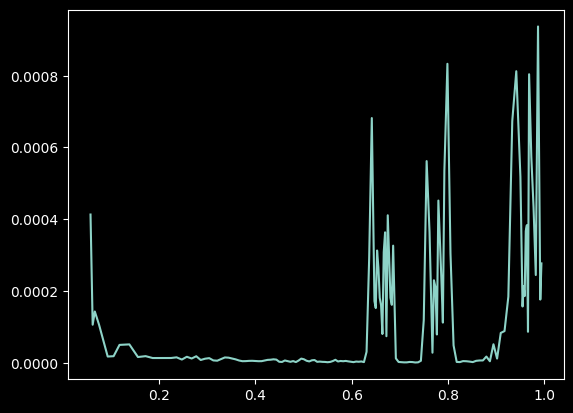

In [11]:
print(solver_1d.rms_residuals)
plt.plot(solver_1d.X[:-1], solver_1d.rms_residuals)

2024-01-20 16:58:54,905 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:94:__init__: Create FyEquilibriumCoordinateSystem <FyEquilibriumCoordinateSystem name='unnamed.unnamed.coordinate_system' />
2024-01-20 16:58:54,994 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:132:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0


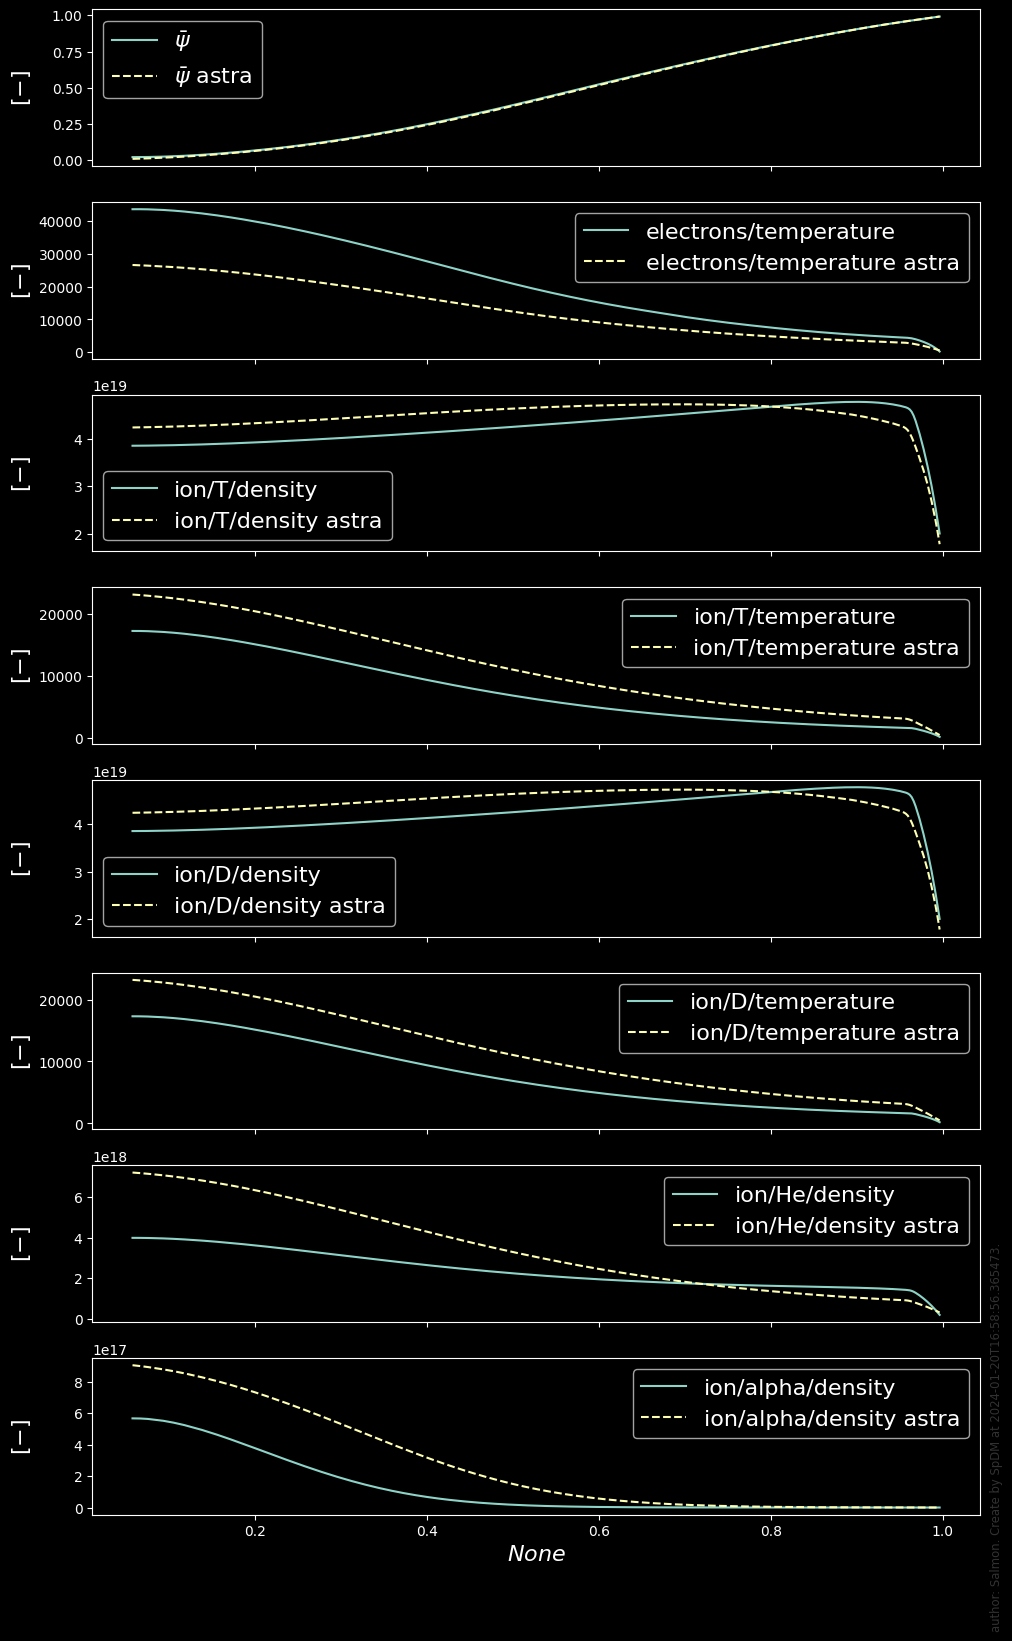

In [12]:
fig = sp_view.plot(
    solver_1d.X,
    [
        (solver_1d.Y[0] * solver._units[0], r"$\bar{\psi}$"),
        (
            Function(
                equilibrium_astra.time_slice.current.profiles_1d.grid.rho_tor_norm,
                equilibrium_astra.time_slice.current.profiles_1d.grid.psi_norm,
            ),
            {"label": r"$\bar{\psi}$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (solver_1d.Y[idx * 2] * solver._units[idx * 2], equ.identifier),
            (
                Path(equ.identifier).get(core_profiles_1d_astra),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for idx, equ in enumerate(solver.equations)
        if equ.identifier != "psi_norm"
    ],
)

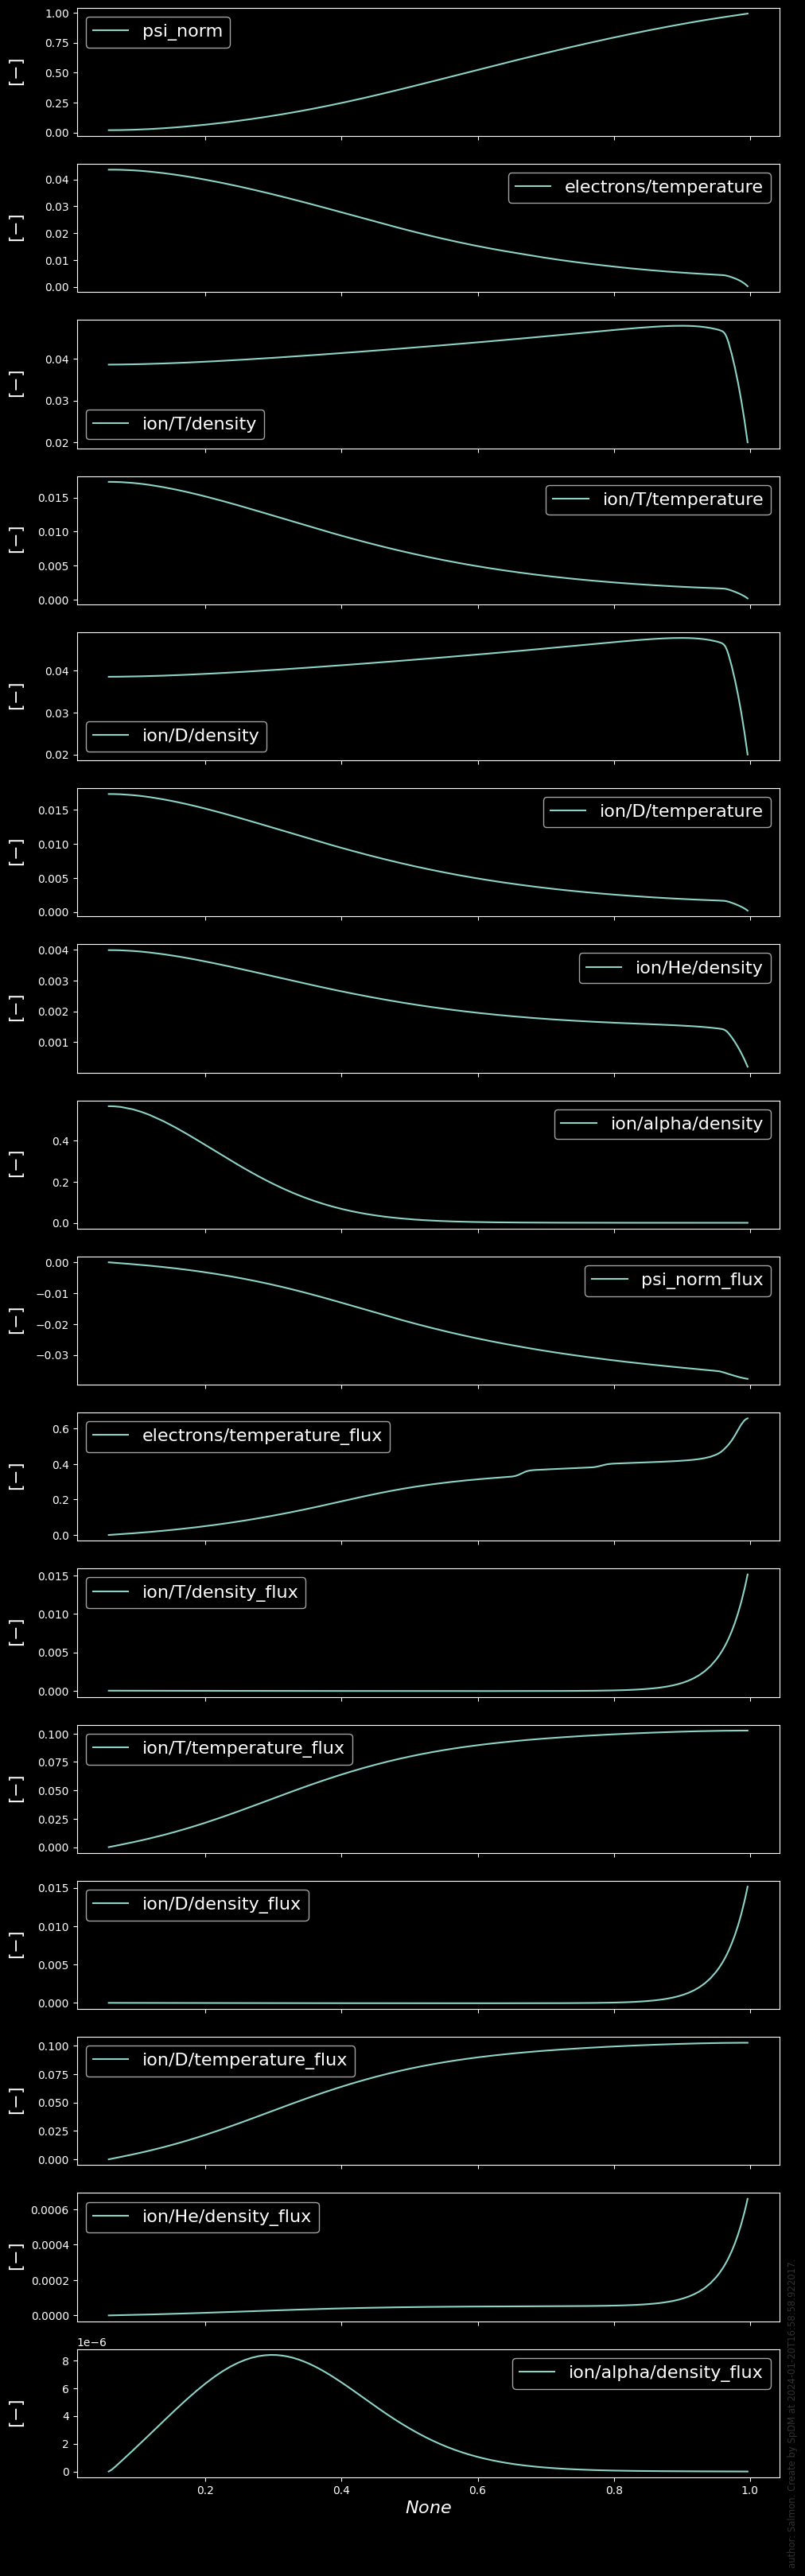

In [13]:
fig = sp_view.plot(
    solver_1d.X,
    *[(solver_1d.Y[idx * 2], equ.identifier) for idx, equ in enumerate(solver.equations)],
    *[(solver_1d.Y[idx * 2 + 1], f"{equ.identifier}_flux") for idx, equ in enumerate(solver.equations)],
)

In [14]:
tokamak.flush()
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

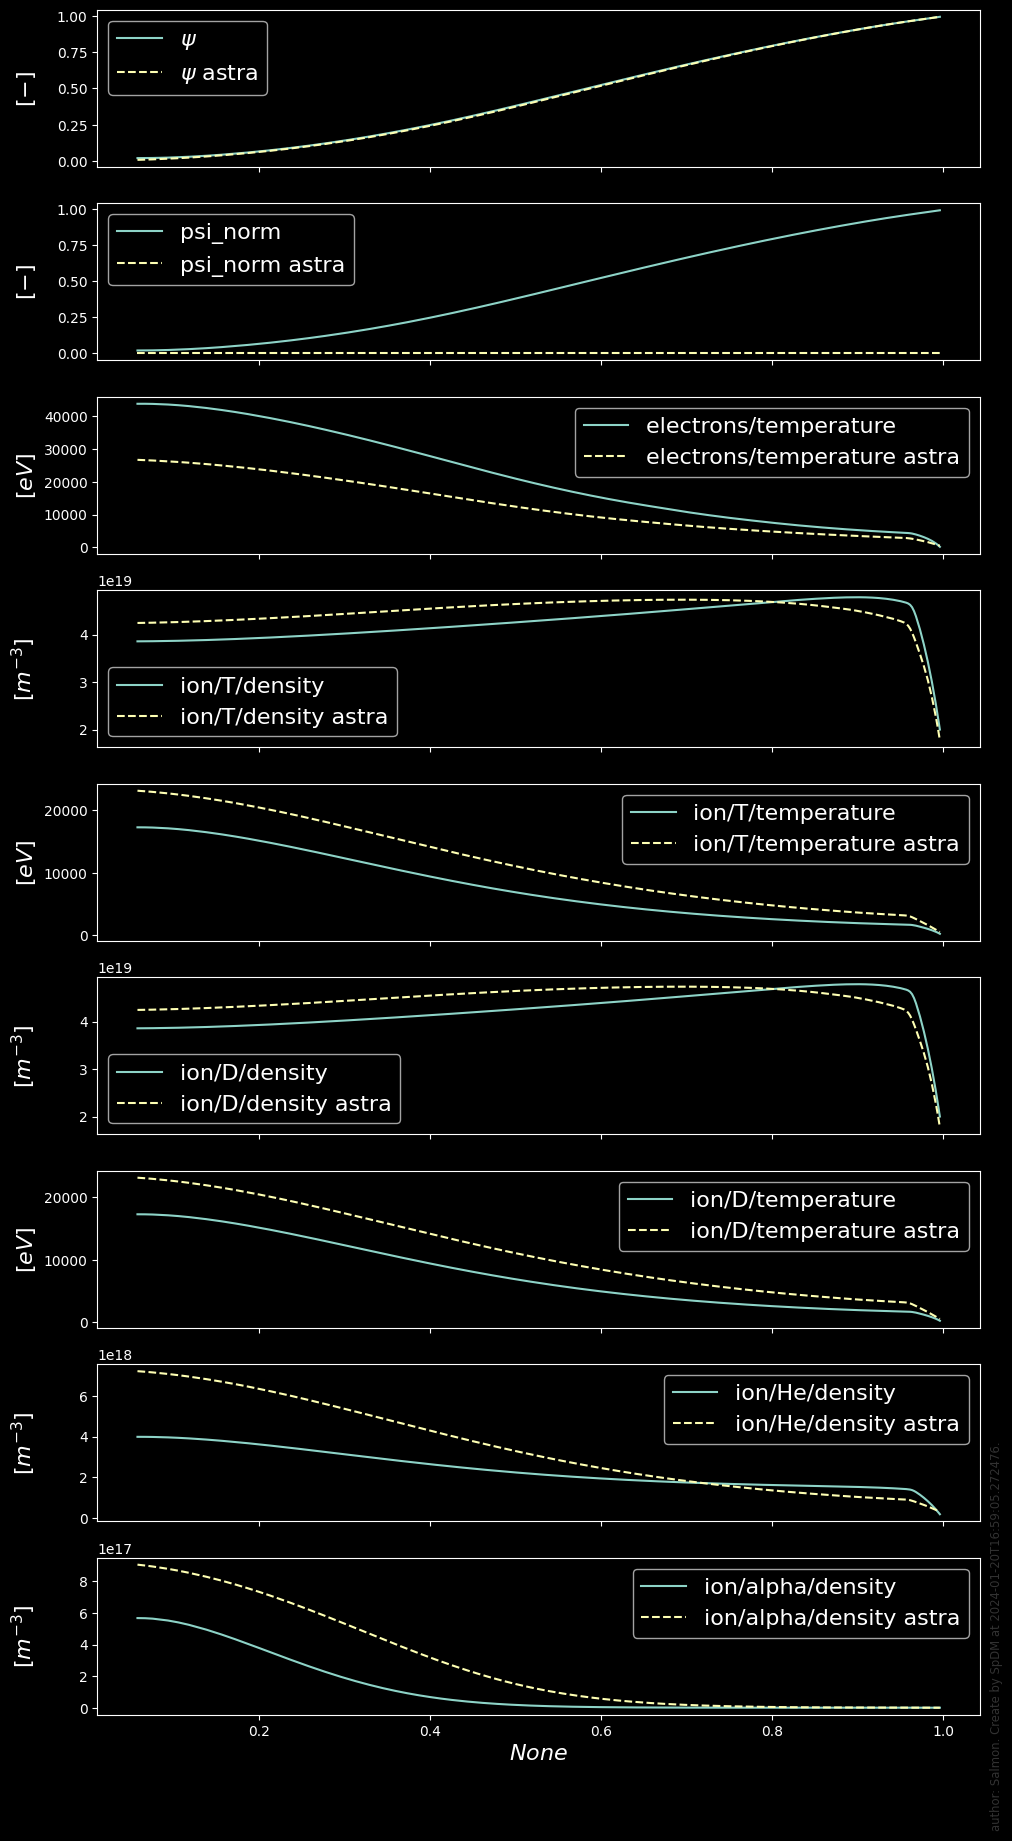

In [15]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi_norm, r"$\psi$"),
        (
            Function(
                equilibrium_astra.time_slice.current.profiles_1d.grid.rho_tor_norm,
                equilibrium_astra.time_slice.current.profiles_1d.grid.psi_norm,
            ),
            {"label": r"$\psi$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi"
    ],
)

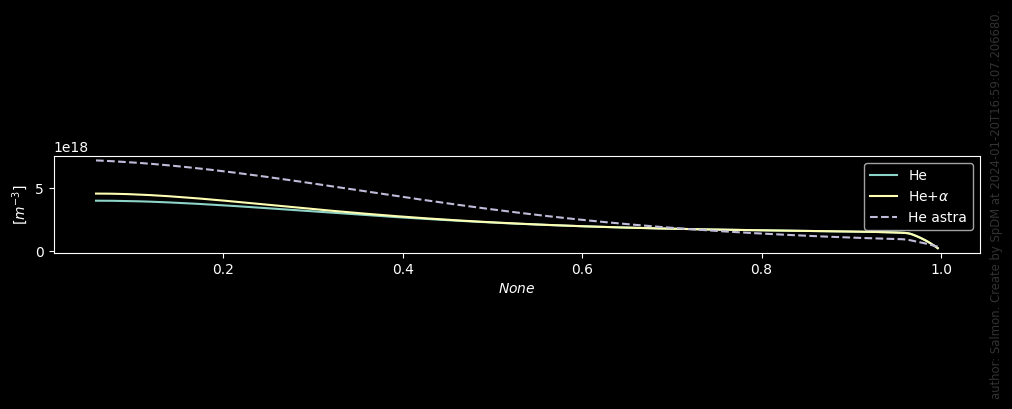

In [16]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        # (core_profiles_1d.ion["alpha"].density, r"$\alpha$"),
        (core_profiles_1d.ion["He"].density, r"He"),
        (core_profiles_1d.ion["He"].density + core_profiles_1d.ion["alpha"].density, r"He+$\alpha$"),
        (core_profiles_1d_astra.ion["He"].density, {"label": f"He astra", "$matplotlib": {"linestyle": "dashed"}}),
    ],
    fontsize=10,
)

In [17]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

ValueError: 
$$\bar{\rho}$ [-]$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x7f065417d090> (for post_execute):


ValueError: 
$$\bar{\rho}$ [-]$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$$\bar{\rho}$ [-]$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1000x600 with 3 Axes>

In [ ]:
source_1d = tokamak.core_sources.source[1].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.electrons.temperature, r"$T_{e}$"),
        *[(ion.temperature, rf"$T_{{{ion.label}}}$") for ion in core_profiles_1d.ion],
    ],  # [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [
        (source_1d.electrons.energy, {"label": r"$Q_{e}$", "$matplotlib": {"linestyle": "-", "marker": "."}}),
        *[(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d

astra_rho_tor_norm = astra_profiles["x"].values
fig = sp_view.plot(
    # source_1d.grid.rho_tor_norm,
    astra_rho_tor_norm,
    (
        Function(astra_rho_tor_norm, astra_profiles["Poh"].values * 1.0e6 / scipy.constants.electron_volt),
        r"$Q_{oh}$ astra",
    ),
    # [
    #     (tokamak.core_sources.source[1].time_slice.current.profiles_1d.electrons.energy, r"$Q_{e}$"),
    #     *[
    #         (ion.energy, rf"$Q_{{{ion.label}}}$")
    #         for ion in tokamak.core_sources.source[1].time_slice.current.profiles_1d.ion
    #     ],
    # ],
    [
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdte"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dte}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdti"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dti}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, (astra_profiles["Pdt"].values) * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dt}$ astra total",
        ),
    ],
    [
        (
            Function(
                astra_rho_tor_norm,
                (
                    astra_profiles["Poh"].values
                    + astra_profiles["Paux"].values
                    # - astra_profiles["Prad"].values
                    - astra_profiles["Pneu"].values
                    - astra_profiles["Peic"].values
                    + astra_profiles["Pdte"].values
                )
                * 1.0e6
                / scipy.constants.electron_volt,
            ),
            r"$Q_{e}$ astra",
        ),
        (source_1d.electrons.energy, r"$Q_{e}$"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=10,
)

In [ ]:
plt.plot(source_1d.grid.rho_tor_norm, source_1d.electrons.energy.__array__() ,label="Qe")
plt.plot(source_1d.electrons.energy.dims[0], source_1d.electrons.energy.__array__())
plt.plot(
    astra_rho_tor_norm,
    (
        astra_profiles["Poh"].values
        + astra_profiles["Paux"].values
        # - astra_profiles["Prad"].values
        - astra_profiles["Pneu"].values
        - astra_profiles["Peic"].values
        + astra_profiles["Pdte"].values
    )
    * 1.0e6
    / scipy.constants.electron_volt,label="Qe astra"
)
plt.legend()

In [ ]:
plt.plot(source_1d.grid.rho_tor_norm, source_1d.electrons.energy.dims[0])

In [ ]:
source_1d = tokamak.core_sources.source[2].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

In [ ]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (solver_1d.Y0[2 * idx], f"d({equ.identifier})/dr"),
                # (solver_1d.Y0[2 * idx + 1], f"d({equ.identifier}_flux)/dr"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for idx, equ in enumerate(solver_1d.equations)
        ],
        [],
    ),
)

In [ ]:
trans_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    (
        [
            (trans_1d.ion[0].particles.d, trans_1d.ion[0].label),
            (trans_1d.ion[1].particles.d, trans_1d.ion[1].label),
        ],
        {"y_label": "D"},
    ),
    (
        [
            (trans_1d.ion[0].particles.v, trans_1d.ion[0].label),
            (trans_1d.ion[1].particles.v, trans_1d.ion[1].label),
        ],
        {"y_label": "v"},
    ),
)

In [ ]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        [
            (source_1d.ion[0].particles, source_1d.ion[0].label),
            (source_1d.ion[2].particles, source_1d.ion[2].label),
        ],
        {"y_label": "Particles"},
    ),
    (
        [
            (source_1d.ion[0].energy, source_1d.ion[0].label),
            (source_1d.ion[2].energy, source_1d.ion[2].label),
        ],
        {"y_label": "Energy"},
    ),
)